In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Load the dataset using Pandas
data = pd.read_csv('energy_efficiency_data.csv')


# Shuffle the dataset
data = data.sample(frac=1, random_state=42)

# Split data into training and testing sets
X = data.drop(['Heating Load', 'Cooling Load'], axis=1)
Y = data['Heating Load']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
# Define the neural network architecture for regression
nn_architecture = [
    {'input_size': X_train.shape[1], 'output_size': 64, 'activation': 'sigmoid'},
    {'input_size': 64, 'output_size': 32, 'activation': 'sigmoid'},
    {'input_size': 32, 'output_size': 1, 'activation': 'linear'}  # Linear activation for regression
]

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivative(x):
    return np.exp(-x) / ((1 + np.exp(-x)) ** 2)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [48]:
def init_layers(nn_architecture):
    parameters = {}
    for i, layer in enumerate(nn_architecture):
        layer_input_size = layer['input_size']
        layer_output_size = layer['output_size']
        parameters[f'W{i}'] = np.random.randn(layer_output_size, layer_input_size) * 0.01
        parameters[f'b{i}'] = np.zeros((layer_output_size, 1))
    return parameters

In [49]:
def forward_propagation(X, parameters, nn_architecture):
    cache = {}
    A = X
    cache[f'X'] = X
    for i, layer in enumerate(nn_architecture):
        W = parameters[f'W{i}']
        b = parameters[f'b{i}']
        Z = np.dot(W, A) + b
        if i == len(nn_architecture) - 1:  # Output layer (linear activation)
            A = Z
        else:
            A = relu(Z)
        cache[f'Z{i}'] = Z
        cache[f'A{i}'] = A
    return A, cache

# Backward propagation
def backward_propagation(Y_hat, Y, cache, parameters, nn_architecture):
    grads = {}
    m = Y.shape[1]  # Number of training examples
    
    for i in reversed(range(len(nn_architecture))):
        if i == len(nn_architecture) - 1:  # Output layer
            dC = 2 * (Y_hat - Y) # sum-of-squares
        else:  # Hidden layer
            dC_next = dC
            Z = cache[f'Z{i}']
            W_next = parameters.get(f'W{i+1}')
            dC = np.dot(W_next.T, dC_next) * relu_derivative(Z)
        
        A_prev = cache.get(f'A{i-1}') if i > 0 else cache.get(f'X')
        grads[f'dW{i}'] = (1 / m) * np.dot(dC, A_prev.T)
        grads[f'db{i}'] = (1 / m) * np.sum(dC, axis=1, keepdims=True)
    return grads

In [50]:
# Loss function (MSE for regression)
def calculate_loss(Y, Y_hat):
    return np.mean((Y_hat - Y) ** 2)

# Update weights and biases
def update(parameters, grads, nn_architecture, learning_rate):
    for i, layer in enumerate(nn_architecture):
        parameters[f'W{i}'] -= learning_rate * grads[f'dW{i}']
        parameters[f'b{i}'] -= learning_rate * grads[f'db{i}']
    return parameters

In [51]:
# Training process with loss tracking
def train(X, Y, nn_architecture, epochs, learning_rate):
    parameters = init_layers(nn_architecture)
    loss_history = []  # To store the loss for each epoch
    for i in range(epochs):
        Y_hat, cache = forward_propagation(X, parameters, nn_architecture)
        loss = calculate_loss(Y, Y_hat)
        loss_history.append(loss)
        grads = backward_propagation(Y_hat, Y, cache, parameters, nn_architecture)
        parameters = update(parameters, grads, nn_architecture, learning_rate)
    return parameters, loss_history


In [56]:
# Train the neural network and collect loss history
trained_parameters, loss_history = train(X_train.T, Y_train.values.reshape(1, -1), nn_architecture, epochs=1000, learning_rate=0.001)


Training RMS Error: 2.7150326437662238
Testing RMS Error: 2.8599528860067354


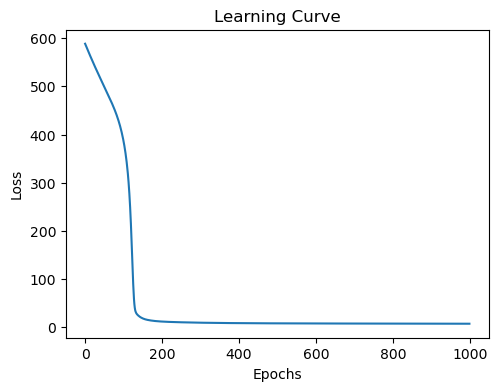

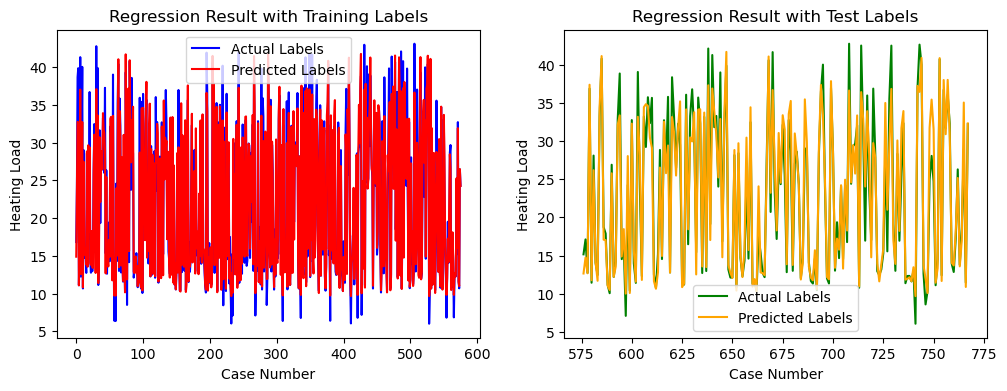

In [59]:

# Predict on training and testing data
Y_train_pred, _ = forward_propagation(X_train.T, trained_parameters, nn_architecture)
Y_test_pred, _ = forward_propagation(X_test.T, trained_parameters, nn_architecture)

# Calculate RMS error for training and testing data
train_rms_error = np.sqrt(np.mean((Y_train_pred - Y_train.values.reshape(1, -1)) ** 2))
test_rms_error = np.sqrt(np.mean((Y_test_pred - Y_test.values.reshape(1, -1)) ** 2))

print(f"Training RMS Error: {train_rms_error}")
print(f"Testing RMS Error: {test_rms_error}")

# Plot the learning curve (loss over epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_history)), loss_history)
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Create a list of case numbers
case_numbers_train = range(len(Y_train))
case_numbers_test = range(len(Y_train), len(Y_train) + len(Y_test))

# Create a line plot for training labels and predictions
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(case_numbers_train, Y_train, label="Actual Labels", color="blue")
plt.plot(case_numbers_train, Y_train_pred[0], label="Predicted Labels", color="red")
plt.xlabel("Case Number")
plt.ylabel("Heating Load")
plt.title("Regression Result with Training Labels")
plt.legend()

# Create a line plot for test labels and predictions
plt.subplot(1, 2, 2)
plt.plot(case_numbers_test, Y_test, label="Actual Labels", color="green")
plt.plot(case_numbers_test, Y_test_pred[0], label="Predicted Labels", color="orange")
plt.xlabel("Case Number")
plt.ylabel("Heating Load")
plt.title("Regression Result with Test Labels")
plt.legend()

plt.show()


In [60]:
trained_parameters['W0']

array([[-2.00123464e-02, -1.85466222e-02,  2.97519292e-02,
        -4.57931582e-02,  2.06584402e-01, -6.05528211e-03,
         4.20343077e-02,  2.39918809e-02],
       [ 6.01773763e-03, -4.40738486e-03,  7.39213495e-04,
         2.06266045e-02,  2.22791040e-02, -1.23089762e-02,
         6.86771886e-02, -4.60690083e-02],
       [ 4.27865123e-03,  8.72577223e-03,  9.58380535e-03,
        -2.45805241e-05,  1.06746615e-02,  7.00572576e-03,
         2.74467101e-02, -6.18910539e-04],
       [ 8.51087068e-03, -1.14857647e-02, -5.75029820e-03,
        -2.30914502e-03,  9.74556784e-03,  1.10189032e-03,
         1.64674594e-03,  4.94651869e-03],
       [-6.95511002e-02, -6.89742247e-02,  7.98761433e-02,
        -1.03032704e-01,  5.02903965e-01,  9.71199749e-03,
         1.36938399e-01,  2.78090239e-02],
       [ 9.25222415e-04,  2.77918130e-02, -5.50166977e-03,
         4.33047062e-03, -1.12553581e-02, -3.12973502e-06,
         2.49414857e-02, -3.48480366e-06],
       [-2.20394837e-02,  2.923241

In [62]:
Y_train_pred, cache = forward_propagation(X_train.T, trained_parameters, nn_architecture)
Y_test_pred, _ = forward_propagation(X_test.T, trained_parameters, nn_architecture)

In [63]:
cache['Z0']

array([[-0.06164513,  0.36402114,  0.39820508, ..., -0.13236506,
         0.36979942,  0.35955728],
       [ 0.04461284, -0.0276555 ,  0.12992092, ..., -0.09495588,
        -0.06886317,  0.02339838],
       [ 0.04811966,  0.02745048,  0.061818  , ...,  0.00202948,
         0.02285385,  0.01540901],
       ...,
       [ 0.01005506, -0.04649722, -0.01445885, ..., -0.00870199,
        -0.03352419, -0.06167877],
       [ 0.12342487,  0.0515866 ,  0.19764805, ...,  0.02804137,
         0.11300169,  0.04102972],
       [-0.06320346,  0.28951428,  0.24945756, ..., -0.0222616 ,
         0.34411347,  0.22324066]])

In [64]:
cache['A0']

array([[0.        , 0.36402114, 0.39820508, ..., 0.        , 0.36979942,
        0.35955728],
       [0.04461284, 0.        , 0.12992092, ..., 0.        , 0.        ,
        0.02339838],
       [0.04811966, 0.02745048, 0.061818  , ..., 0.00202948, 0.02285385,
        0.01540901],
       ...,
       [0.01005506, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12342487, 0.0515866 , 0.19764805, ..., 0.02804137, 0.11300169,
        0.04102972],
       [0.        , 0.28951428, 0.24945756, ..., 0.        , 0.34411347,
        0.22324066]])

In [65]:
np.exp(-8.42894262)

0.00021845235546442263